## SQL - 15 Days of Learning SQL

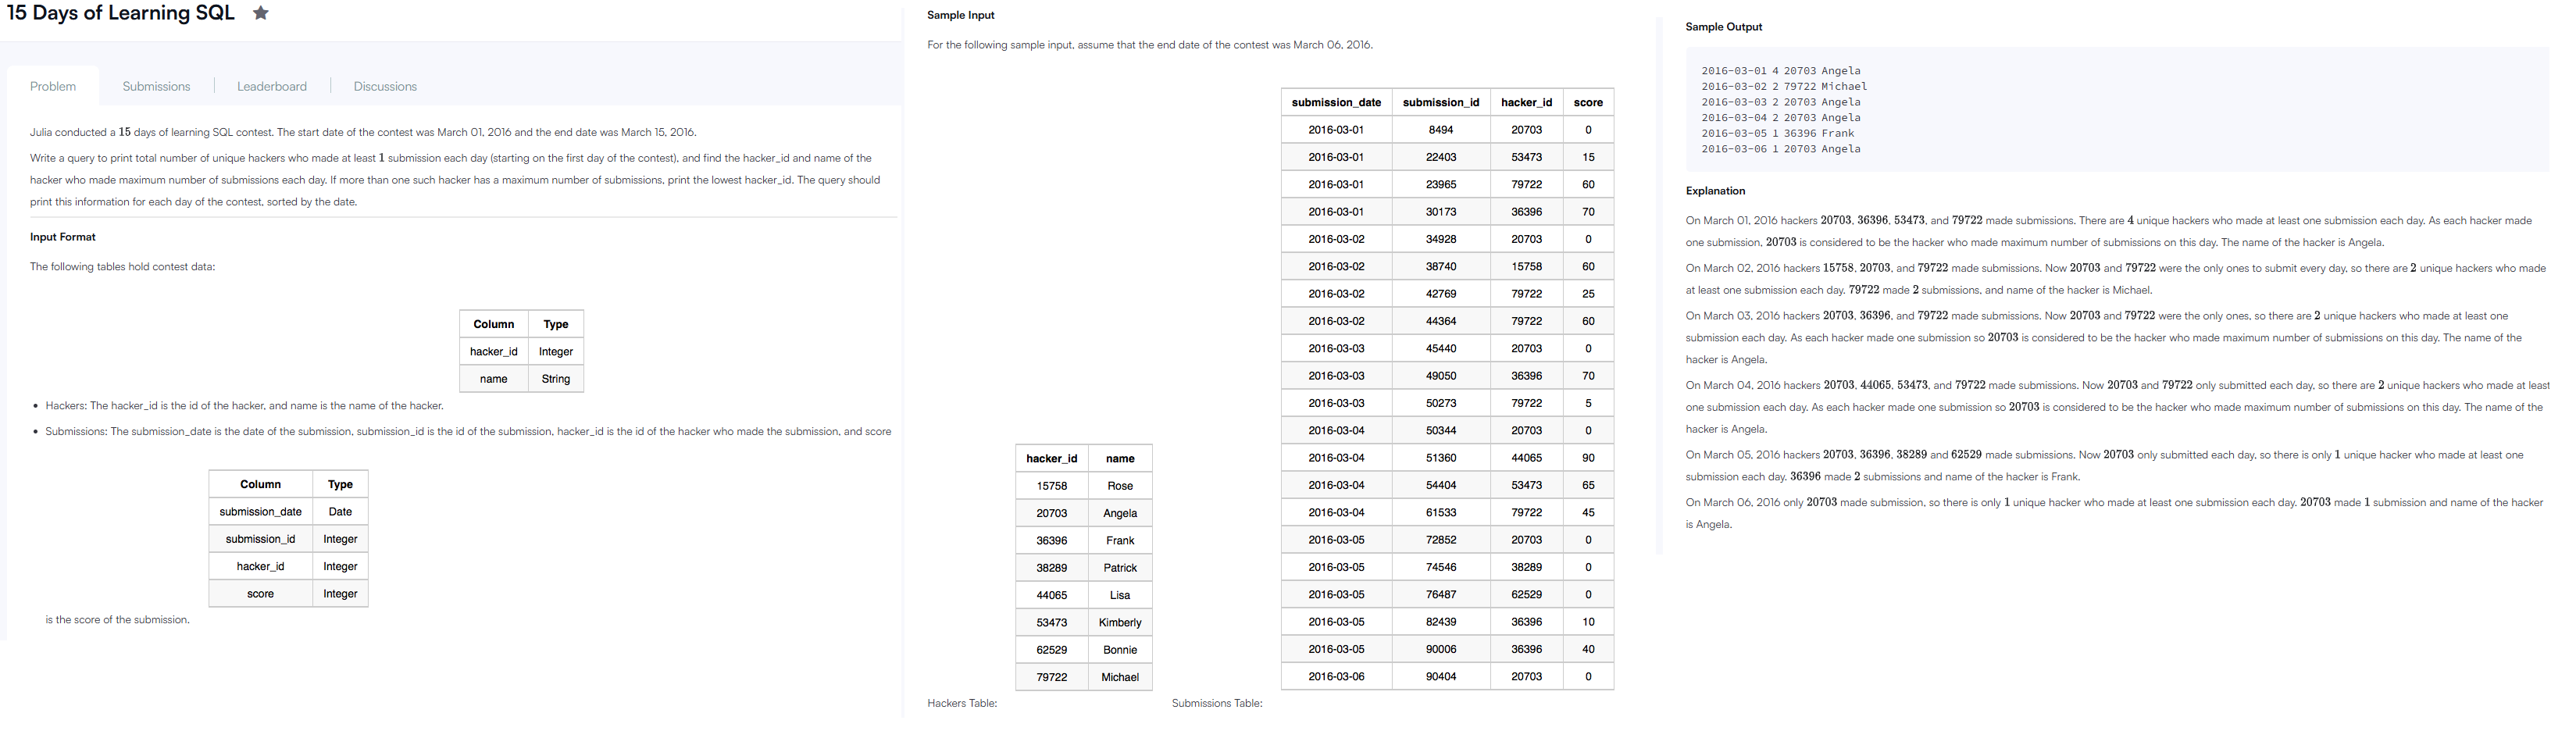

In [0]:
## Import libraries
from pyspark.sql import SparkSession
from pyspark.sql.types import StructField, StructType, StringType, IntegerType, DateType
from pyspark.sql.functions import col, sum, count, rank, countDistinct, dayofmonth, when
from pyspark.sql import functions as F
from pyspark.sql.window import Window

In [0]:
spark = SparkSession.builder.appName('15 Days of Learning SQL').getOrCreate()

In [0]:
## Create Schemas
hackers_schema = StructType([StructField('hacker_id', IntegerType(), False),
                            StructField('name', StringType(), False)])

submissions_schema = StructType([StructField('submission_date', DateType(), False),
                                 StructField('submission_id', IntegerType(), False),
                                 StructField('hacker_id', IntegerType(), False),
                                 StructField('score', IntegerType(), False)])

In [0]:
dbutils.fs.ls('/FileStore/HackerRank')
# dbutils.fs.rm('dbfs:/FileStore/HackerRank/Submissions.csv', True)

Out[4]: [FileInfo(path='dbfs:/FileStore/HackerRank/Challenges.csv', name='Challenges.csv', size=12481, modificationTime=1730586225000),
 FileInfo(path='dbfs:/FileStore/HackerRank/Colleges.csv', name='Colleges.csv', size=6350, modificationTime=1730585150000),
 FileInfo(path='dbfs:/FileStore/HackerRank/Contests.csv', name='Contests.csv', size=4913, modificationTime=1730585150000),
 FileInfo(path='dbfs:/FileStore/HackerRank/Friends.csv', name='Friends.csv', size=134, modificationTime=1730923823000),
 FileInfo(path='dbfs:/FileStore/HackerRank/Functions.csv', name='Functions.csv', size=791, modificationTime=1730936857000),
 FileInfo(path='dbfs:/FileStore/HackerRank/Hackers.csv', name='Hackers.csv', size=6856, modificationTime=1730763742000),
 FileInfo(path='dbfs:/FileStore/HackerRank/Occupations.csv', name='Occupations.csv', size=302, modificationTime=1731016529000),
 FileInfo(path='dbfs:/FileStore/HackerRank/Packages.csv', name='Packages.csv', size=197, modificationTime=1730923823000),
 Fi

In [0]:
## Create data frames from CSV
hackers_df = spark.read.csv('dbfs:/FileStore/HackerRank/Hackers.csv', schema = hackers_schema, header = True)
submissions_df = spark.read.csv('dbfs:/FileStore/HackerRank/Submissions.csv', schema = submissions_schema, header = True)


In [0]:
## Create pyspark SQL views
hackers_df.createOrReplaceTempView('hackers')
submissions_df.createOrReplaceTempView('submissions')

In [0]:
%sql
select * from submissions limit 10

submission_date,submission_id,hacker_id,score
2016-03-01,48,650,0
2016-03-01,119,3162,0
2016-03-01,141,4413,0
2016-03-01,203,5478,0
2016-03-01,215,5509,0
2016-03-01,252,5990,0
2016-03-01,264,7460,0
2016-03-01,348,7865,0
2016-03-01,395,7897,0
2016-03-01,452,7978,0


### Expected Correct Answer
2016-03-01 112 81314 Denise \
2016-03-02 59 39091 Ruby \
2016-03-03 51 18105 Roy \
2016-03-04 49 533 Patrick \
2016-03-05 49 7891 Stephanie \
2016-03-06 49 84307 Evelyn \
2016-03-07 35 80682 Deborah \
2016-03-08 35 10985 Timothy \
2016-03-09 35 31221 Susan \
2016-03-10 35 43192 Bobby \
2016-03-11 35 3178 Melissa \
2016-03-12 35 54967 Kenneth \
2016-03-13 35 30061 Julia \
2016-03-14 35 32353 Rose \
2016-03-15 35 27789 Helen 

The problem is broken down into 3 steps
- 1. For each day find the hacker with most submission [top hacker]
- 2. For each day find unique hacker who has submitted on consecutive days without a break.\
      For eg: Hacker 1 submission on Day 1,2,3
              Hacker 2 submission on Day 10,11,12,13
- 3. Combine results of 1. and 2. by submission date


## SQL Solution

In [0]:
%sql
-- Final SQL query
with s2 as (
  select * from 
  (
    select si.hacker_id, si.submission_date,h.name, count(*) cnt, rank() over (partition by si.submission_date order by count(*) desc, si.hacker_id, h.name) rnk
    from submissions si join hackers h on si.hacker_id = h.hacker_id 
     group by si.submission_date, si.hacker_id, h.name
  ) where rnk =1
)
--Main query starts here
select distinct s.submission_date,
(  select count(*) from 
  (
  select hacker_id,count(distinct submission_date) as subs from submissions 
    where submission_date<=s.submission_date
    group by hacker_id
  having count(distinct submission_date)=day(s.submission_date)
  )
) as unique_hacker_count
,(select max(s2.hacker_id) from s2 where s.submission_date=s2.submission_date ) as hacker_id
,(select max(s2.name) from s2 where s.submission_date=s2.submission_date ) as name
from submissions s
order by s.submission_date

submission_date,unique_hacker_count,hacker_id,name
2016-03-01,112,81314,Denise
2016-03-02,59,39091,Ruby
2016-03-03,51,18105,Roy
2016-03-04,49,533,Patrick
2016-03-05,49,7891,Stephanie
2016-03-06,49,84307,Evelyn
2016-03-07,35,80682,Deborah
2016-03-08,35,10985,Timothy
2016-03-09,35,31221,Susan
2016-03-10,35,43192,Bobby


### SQL Alternative with Window function

- 1. Below query is the alternative of the CTE above

In [0]:
%sql
select submission_date, count(*) cnt
from 
  (
    select *, 
          count(submission_date) over(partition by hacker_id order by submission_date range between unbounded preceding and current row) distinct_submission_count
          ,day(submission_date) day_num
    from (select distinct submission_date, hacker_id from submissions) 
  )
where distinct_submission_count=day_num
  group by submission_date
  order by submission_date

submission_date,cnt
2016-03-01,112
2016-03-02,59
2016-03-03,51
2016-03-04,49
2016-03-05,49
2016-03-06,49
2016-03-07,35
2016-03-08,35
2016-03-09,35
2016-03-10,35


### Python Solution

- 1. Top hacker

In [0]:
window_rnk = Window.partitionBy(col('si.submission_date')).orderBy(col('cnt').desc(), col('si.hacker_id'), col('h.name'))

top_hacker_df = submissions_df.alias('si').join(hackers_df.alias('h'), ['hacker_id'], how='inner')\
    .groupBy(col('si.submission_date'), col('si.hacker_id'), col('h.name'))\
        .agg(count('*').alias('cnt'))\
            .withColumn('rnk', rank().over(window_rnk))\
                .filter(col('rnk') == 1)\
                    .select(['submission_date', 'hacker_id', 'name'])
        

display(top_hacker_df)

submission_date,hacker_id,name
2016-03-01,81314,Denise
2016-03-02,39091,Ruby
2016-03-03,18105,Roy
2016-03-04,533,Patrick
2016-03-05,7891,Stephanie
2016-03-06,84307,Evelyn
2016-03-07,80682,Deborah
2016-03-08,10985,Timothy
2016-03-09,31221,Susan
2016-03-10,43192,Bobby


- 2. Unique Hacker Count

In [0]:
# select count(*), submission_date from 
# (
# select *, count(submission_date) over(partition by hacker_id order by submission_date range between unbounded preceding and current row) distinct_submission_count , day(submission_date) day_num
# from (select distinct submission_date, hacker_id from submissions) 
# )
# where distinct_submission_count=day_num
# group by submission_date
# order by submission_date
window_part = Window.partitionBy(col('hacker_id')).orderBy(col('submission_date')).rangeBetween(Window.unboundedPreceding, Window.currentRow)
unique_hacker_count = submissions_df.select(['submission_date', 'hacker_id']).distinct()\
    .withColumn('distinct_submission_count', count(col('submission_date')).over(window_part))\
        .withColumn('day_num', dayofmonth(col('submission_date')))\
            .filter(col('distinct_submission_count') == col('day_num'))\
                .groupBy(col('submission_date')).agg(count('*').alias('unique_hacker_count')).orderBy(col('submission_date'))

display(unique_hacker_count)

submission_date,unique_hacker_count
2016-03-01,112
2016-03-02,59
2016-03-03,51
2016-03-04,49
2016-03-05,49
2016-03-06,49
2016-03-07,35
2016-03-08,35
2016-03-09,35
2016-03-10,35


In [0]:
## JOIN top hacker dataframe and unique hacker count dataframe on submission date

result_df = unique_hacker_count.join(top_hacker_df, ['submission_date'], how = 'inner')

display(result_df)

submission_date,unique_hacker_count,hacker_id,name
2016-03-01,112,81314,Denise
2016-03-02,59,39091,Ruby
2016-03-03,51,18105,Roy
2016-03-04,49,533,Patrick
2016-03-05,49,7891,Stephanie
2016-03-06,49,84307,Evelyn
2016-03-07,35,80682,Deborah
2016-03-08,35,10985,Timothy
2016-03-09,35,31221,Susan
2016-03-10,35,43192,Bobby


### Below cells are rough notes while writting the code

In [0]:
# with s2 as (
#   select * from 
#   (
#     select si.hacker_id, si.submission_date,h.name, count(*) cnt, rank() over (partition by si.submission_date order by count(*) desc, si.hacker_id, h.name) rnk
#     from submissions si join hackers h on si.hacker_id = h.hacker_id 
#      group by si.submission_date, si.hacker_id, h.name
#   ) where rnk =1
# )
## Get top hacker id and name
window_rank = Window.partitionBy(['submission_date']).orderBy(count('*').desc(), col('hacker_id').asc(), col('name').asc())

top_hacker_df = submissions_df.join(hackers_df, ['hacker_id'])\
  .groupby(['submission_date','hacker_id','name'])\
    .agg(count('*').alias('cnt'), rank().over(window_rank).alias('rnk'))

top_hacker_df=top_hacker_df.where(col('rnk') == 1)

display(top_hacker_df.limit(50))


submission_date,hacker_id,name,cnt,rnk
2016-03-01,81314,Denise,3,1
2016-03-02,39091,Ruby,3,1
2016-03-03,18105,Roy,2,1
2016-03-04,533,Patrick,2,1
2016-03-05,7891,Stephanie,2,1
2016-03-06,84307,Evelyn,4,1
2016-03-07,80682,Deborah,4,1
2016-03-08,10985,Timothy,2,1
2016-03-09,31221,Susan,3,1
2016-03-10,43192,Bobby,2,1


In [0]:
# --Main query starts here
# select distinct s.submission_date,
# (  select count(*) from 
#   (
#   select hacker_id,count(distinct submission_date) as subs from submissions 
#     where submission_date<=s.submission_date
#     group by hacker_id
#   having count(distinct submission_date)=day(s.submission_date)
#   )
# ) as unique_hacker_count
# ,(select max(s2.hacker_id) from s2 where s.submission_date=s2.submission_date ) as hacker_id
# ,(select max(s2.name) from s2 where s.submission_date=s2.submission_date ) as name
# from submissions s
# order by s.submission_date
hacker_id_df = submissions_df.alias('s')\
    .join(submissions_df.alias('subs'), col('subs.submission_date') <= col('s.submission_date'), how='inner')\
        .groupBy(col('subs.hacker_id'))\
            .agg(countDistinct(col('subs.submission_date')).alias('cnt'))\
                .where(col('cnt') == dayofmonth(col('s.submission_date')))

display(hacker_id_df)


---------------------------------------------------------------------------
AnalysisException                         Traceback (most recent call last)
File <command-2732965026679659>:15
      1 # --Main query starts here
      2 # select distinct s.submission_date,
      3 # (  select count(*) from 
   (...)
     13 # from submissions s
     14 # order by s.submission_date
---> 15 hacker_id_df = submissions_df.alias('s')\
     16     .join(submissions_df.alias('subs'), col('subs.submission_date') <= col('s.submission_date'), how='inner')\
     17         .groupBy(col('subs.hacker_id'))\
     18             .agg(countDistinct(col('subs.submission_date')).alias('cnt'))\
     19                 .where(col('cnt') == dayofmonth(col('s.submission_date')))
     21 display(hacker_id_df)

File /databricks/spark/python/pyspark/instrumentation_utils.py:48, in _wrap_function.<locals>.wrapper(*args, **kwargs)
     46 start = time.perf_counter()
     47 try:
---> 48     res = func(*args, **kwargs)


In [0]:
# select count(*) from 
#   (
#   select hacker_id,count(distinct submission_date) as subs from submissions 
#     where submission_date<=s.submission_date
#     group by hacker_id
#   having count(distinct submission_date)=day(s.submission_date)
#   )
## Get daily count
# submissions_sub_df = submissions_df
#### spark.conf spark.sql.analyzer.failAmbiguousSelfJoin to false
# Step 1: Create a subquery to count distinct submission dates per hacker
# Step 1: Create a DataFrame with distinct submission dates
distinct_dates_df = submissions_df.select(col("submission_date").alias('d_submission_date')).distinct()

# Step 2: Calculate unique hacker count for each submission date
# We will use a left join to get the unique hacker count for each submission date
result_df = (
    distinct_dates_df.alias("s1")
    .join(
        submissions_df.alias("s2"),
        F.col("s2.submission_date") <= F.col("s1.d_submission_date"),
        "left"
    )\
        .groupBy(col('d_submission_date'))\
        .agg(count(col('submission_date')).alias('distint_count'))
)

# Step 3: Filter to get only those counts that match the day of the month condition
# final_result = result_df.filter(F.col("hacker_id_count") == F.dayofmonth(F.col("s1.submission_date")))

# Step 4: Select final columns and order by submission date
# final_result = final_result.select("s1.submission_date", "hacker_id_count").orderBy("s1.submission_date")

# display(result_df.filter(col("submission_date") == '2016-03-02').orderBy(col('d_submission_date')))
display(result_df.orderBy(col('d_submission_date')))

d_submission_date,distint_count
2016-03-01,114
2016-03-02,271
2016-03-03,398
2016-03-04,540
2016-03-05,695
2016-03-06,850
2016-03-07,959
2016-03-08,1111
2016-03-09,1273
2016-03-10,1385


In [0]:
%sql
-- Check submission table if any hacker had more than one submission in a day
select count(*), submission_id, hacker_id from submissions
group by submission_id, hacker_id 
having count(*)>1

count(1),submission_id,hacker_id


In [0]:
%sql
--Write a query to print total number of unique hackers who made at least 1 submission each day [starting on the first day of the --contest], and find the hacker_id and name of the hacker who made maximum number of submissions each day. 

select * from hackers ha 
join submissions su on ha.hacker_id=su.hacker_id
where su.submission_date = '2016-03-01'


hacker_id,name,submission_date,submission_id,hacker_id,score
650,Kimberly,2016-03-01,48,650,0
3162,Linda,2016-03-01,119,3162,0
4413,Marilyn,2016-03-01,141,4413,0
5478,Julia,2016-03-01,203,5478,0
5509,Kevin,2016-03-01,215,5509,0
5990,Paul,2016-03-01,252,5990,0
7460,Donna,2016-03-01,264,7460,0
7865,Michelle,2016-03-01,348,7865,0
7897,Gerald,2016-03-01,395,7897,0
7978,Walter,2016-03-01,452,7978,0


In [0]:
%sql
select submission_date, cnt, hacker_id, name, rnk from (
select su.submission_date, su.cnt, su.max_score, 
   rank() over (partition by su.submission_date order by su.cnt desc, su.max_score desc, su.hacker_id) rnk, su.hacker_id, ha.name
from hackers ha
join (
  select submission_date, hacker_id, count(*) cnt, max(score) as max_score
  from submissions su
    where su.submission_date = '2016-03-01'
  group by submission_date, hacker_id
) su
on su.hacker_id = ha.hacker_id
)
-- where rnk = 1 order by submission_date


submission_date,cnt,hacker_id,name,rnk
2016-03-01,3,81314,Denise,1
2016-03-01,1,2697,Earl,2
2016-03-01,1,22750,Mildred,3
2016-03-01,1,43192,Bobby,4
2016-03-01,1,83968,Julie,5
2016-03-01,1,97530,Amy,6
2016-03-01,1,19516,Brian,7
2016-03-01,1,56909,Arthur,8
2016-03-01,1,83509,Sharon,9
2016-03-01,1,89737,Jeremy,10


In [0]:
%sql
  
  select submission_date, daily_count, hacker_id, name from (
  select *,
  rank() over (partition by submission_date order by cnt desc, max_score desc, hacker_id) as rnk,
  count(*) over (partition by submission_date) as daily_count
  from 
  (
  select su.submission_date, su.hacker_id, 
  count(*) as cnt, 
  max(score) as max_score, ha.name 
  from submissions su
  join hackers ha 
  on ha.hacker_id = su.hacker_id
  where su.submission_date = '2016-03-02'
  group by su.submission_date, su.hacker_id, ha.name
  )
  )
  -- where rnk =1

submission_date,daily_count,hacker_id,name
2016-03-02,144,83376,Walter
2016-03-02,144,3162,Linda
2016-03-02,144,98981,Rose
2016-03-02,144,9630,Marilyn
2016-03-02,144,70115,Stephen
2016-03-02,144,33863,Patrick
2016-03-02,144,53295,Brian
2016-03-02,144,46328,Clarence
2016-03-02,144,56978,Melissa
2016-03-02,144,37187,John


In [0]:
%sql
  select su.submission_date, su.hacker_id, 
  count(*) as cnt, 
  max(score) as max_score, ha.name 
  from submissions su
  join hackers ha 
  on ha.hacker_id = su.hacker_id
  where su.submission_date = '2016-03-02'
  group by su.submission_date, su.hacker_id, ha.name
  order by 3 desc,4 desc 

submission_date,hacker_id,cnt,max_score,name
2016-03-02,98981,3,65,Rose
2016-03-02,39091,3,55,Ruby
2016-03-02,66648,2,95,Virginia
2016-03-02,99789,2,90,Joshua
2016-03-02,89781,2,80,Jeffrey
2016-03-02,60516,2,65,Martin
2016-03-02,21973,2,50,Albert
2016-03-02,69030,2,45,Carl
2016-03-02,73967,2,40,Ruby
2016-03-02,78408,2,35,Mildred


In [0]:
%sql
-- ## List of hackers submitted every day
select hacker_id from submissions
group by  hacker_id
having count(*) = 15



hacker_id
34234
22917
7865
7460
34369
27064
33863
26093
5478
8150


In [0]:
%sql
select * from submissions where hacker_id = 39091

submission_date,submission_id,hacker_id,score
2016-03-01,3939,39091,0
2016-03-02,10653,39091,0
2016-03-02,10866,39091,25
2016-03-02,13066,39091,55
2016-03-05,31414,39091,70
2016-03-08,53388,39091,60


In [0]:

%sql
-- ## List of hackers submitted every day
select *  
from submissions su
join (
  select hacker_id from submissions
  group by  hacker_id
  having count(*) = 15
  ) as daily_su
on daily_su.hacker_id=su.hacker_id
where su.submission_date = '2016-03-02'


submission_date,submission_id,hacker_id,score,hacker_id
2016-03-02,5851,650,0,650
2016-03-02,5970,3162,0,3162
2016-03-02,6171,4413,0,4413
2016-03-02,6191,5478,0,5478
2016-03-02,6395,5509,0,5509
2016-03-02,6464,5990,0,5990
2016-03-02,6559,7460,0,7460
2016-03-02,6588,7865,0,7865
2016-03-02,6606,7897,0,7897
2016-03-02,6608,7978,0,7978


In [0]:
%sql
select s.submission_date,
	(select count(hc.hacker_id) from (
	select hacker_id,count(distinct submission_date) as subs from submissions 
	where submission_date<=s.submission_date
	group by hacker_id
	having count(distinct submission_date)=day(s.submission_date)) as hc),
(select top 1 si.hacker_id from submissions si where si.submission_date=s.submission_date group by si.hacker_id order by count(*) desc,si.hacker_id),
(select top 1 h.name from submissions si join hackers h on h.hacker_id=si.hacker_id where si.submission_date=s.submission_date group by si.hacker_id,h.name order by count(*) desc,si.hacker_id) 
from submissions s
group by s.submission_date
order by s.submission_date

---------------------------------------------------------------------------
ParseException                            Traceback (most recent call last)
File <command-2045394073834202>:7
      5     display(df)
      6     return df
----> 7   _sqldf = ____databricks_percent_sql()
      8 finally:
      9   del ____databricks_percent_sql

File <command-2045394073834202>:4, in ____databricks_percent_sql()
      2 def ____databricks_percent_sql():
      3   import base64
----> 4   df = spark.sql(base64.standard_b64decode("U0VMRUNUCiAgICAgaGFja2VyX2lkCiAgICAsbmFtZQogICAgLHN1Ym1pc3Npb25fZGF0ZQogICAgLHN1YnMKRlJPTSBzdWJtaXNzaW9ucwpTVEFSVCBXSVRIIHN1Ym1pc3Npb25fZGF0ZSA9IERBVEUgJzIwMTYtMDMtMDEnCkNPTk5FQ1QgQlkgCiAgICBQUklPUiBzdWJtaXNzaW9uX2RhdGUgPSBzdWJtaXNzaW9uX2RhdGUgLSAxCiAgICBBTkQgUFJJT1IgaGFja2VyX2lkID0gaGFja2VyX2lk").decode())
      5   display(df)
      6   return df

File /databricks/spark/python/pyspark/instrumentation_utils.py:48, in _wrap_function.<locals>.wrapper(*args, **kwargs)
     

In [0]:
%sql
select s.submission_date,
	(select count(hc.hacker_id) from (
	select hacker_id,count(distinct submission_date) as subs from submissions 
	where submission_date<=s.submission_date
	group by hacker_id
	having count(distinct submission_date)=day(s.submission_date)) as hc)
from submissions s
group by s.submission_date
order by s.submission_date

---------------------------------------------------------------------------
AnalysisException                         Traceback (most recent call last)
File <command-2008687301158226>:7
      5     display(df)
      6     return df
----> 7   _sqldf = ____databricks_percent_sql()
      8 finally:
      9   del ____databricks_percent_sql

File <command-2008687301158226>:4, in ____databricks_percent_sql()
      2 def ____databricks_percent_sql():
      3   import base64
----> 4   df = spark.sql(base64.standard_b64decode("c2VsZWN0IHMuc3VibWlzc2lvbl9kYXRlLAoJKHNlbGVjdCBjb3VudChoYy5oYWNrZXJfaWQpIGZyb20gKAoJc2VsZWN0IGhhY2tlcl9pZCxjb3VudChkaXN0aW5jdCBzdWJtaXNzaW9uX2RhdGUpIGFzIHN1YnMgZnJvbSBzdWJtaXNzaW9ucyAKCXdoZXJlIHN1Ym1pc3Npb25fZGF0ZTw9cy5zdWJtaXNzaW9uX2RhdGUKCWdyb3VwIGJ5IGhhY2tlcl9pZAoJaGF2aW5nIGNvdW50KGRpc3RpbmN0IHN1Ym1pc3Npb25fZGF0ZSk9ZGF5KHMuc3VibWlzc2lvbl9kYXRlKSkgYXMgaGMpCmZyb20gc3VibWlzc2lvbnMgcwpncm91cCBieSBzLnN1Ym1pc3Npb25fZGF0ZQpvcmRlciBieSBzLnN1Ym1pc3Npb25fZGF0ZQ==").decode())
   

In [0]:
%sql
select distinct s.submission_date,
(  select count(*) from 
  (
  select hacker_id,count(distinct submission_date) as subs from submissions 
    where submission_date<=s.submission_date
    group by hacker_id
  having count(distinct submission_date)=day(s.submission_date)
  )
)
from submissions s
order by s.submission_date

  

submission_date,"scalarsubquery(submission_date, submission_date)"
2016-03-01,112
2016-03-02,59
2016-03-03,51
2016-03-04,49
2016-03-05,49
2016-03-06,49
2016-03-07,35
2016-03-08,35
2016-03-09,35
2016-03-10,35


In [0]:
%sql
--Good one
select * from 
(
select hacker_id, submission_date, cnt, rank() over (partition by submission_date order by cnt desc, hacker_id) rnk
from (
    select hacker_id, submission_date, count(*) cnt
    from submissions 
    -- where submission_date='2016-03-02' 
    group by submission_date, hacker_id
)
-- order by submission_date,cnt desc 
)
where rnk =1

hacker_id,submission_date,cnt,rnk
81314,2016-03-01,3,1
39091,2016-03-02,3,1
18105,2016-03-03,2,1
533,2016-03-04,2,1
7891,2016-03-05,2,1
84307,2016-03-06,4,1
80682,2016-03-07,4,1
10985,2016-03-08,2,1
31221,2016-03-09,3,1
43192,2016-03-10,2,1


In [0]:
%sql
-- Good one - dont change
with s1 as (
select * from (
    select hacker_id, submission_date, count(*) cnt, rank() over (partition by submission_date order by count(*) desc, hacker_id) rnk
    from submissions 
    -- where submission_date='2016-03-02' 
    group by submission_date, hacker_id
    -- order by submission_date, cnt desc, hacker_id
    ) where rnk =1
        )
, s2 as (
  select * from (
    select si.hacker_id, si.submission_date,h.name, count(*) cnt, rank() over (partition by si.submission_date order by count(*) desc, si.hacker_id, h.name) rnk
    from submissions si join hackers h on si.hacker_id = h.hacker_id 
    -- where submission_date='2016-03-02' 
    group by si.submission_date, si.hacker_id, h.name
    -- order by submission_date, cnt desc, hacker_id
    ) where rnk =1
)
select distinct s.submission_date,(select max(s1.hacker_id) from s1 where s.submission_date=s1.submission_date ) as hacker_id
, (select max(s2.name) from s2 where s.submission_date=s2.submission_date ) as name
from submissions s
-- group by s.submission_date
order by s.submission_date

submission_date,hacker_id,name
2016-03-01,81314,Denise
2016-03-02,39091,Ruby
2016-03-03,18105,Roy
2016-03-04,533,Patrick
2016-03-05,7891,Stephanie
2016-03-06,84307,Evelyn
2016-03-07,80682,Deborah
2016-03-08,10985,Timothy
2016-03-09,31221,Susan
2016-03-10,43192,Bobby


In [0]:
%sql
-- Good one - from above
with s1 as (
select * from (
    select hacker_id, submission_date, count(*) cnt, rank() over (partition by submission_date order by count(*) desc, hacker_id) rnk
    from submissions 
    -- where submission_date='2016-03-02' 
    group by submission_date, hacker_id
    -- order by submission_date, cnt desc, hacker_id
    ) where rnk =1
        )
, s2 as (
  select * from (
    select si.hacker_id, si.submission_date,h.name, count(*) cnt, rank() over (partition by si.submission_date order by count(*) desc, si.hacker_id, h.name) rnk
    from submissions si join hackers h on si.hacker_id = h.hacker_id 
    -- where submission_date='2016-03-02' 
    group by si.submission_date, si.hacker_id, h.name
    -- order by submission_date, cnt desc, hacker_id
    ) where rnk =1
)
select distinct s.submission_date,
(  select count(*) from 
  (
  select hacker_id,count(distinct submission_date) as subs from submissions 
    where submission_date<=s.submission_date
    group by hacker_id
  having count(distinct submission_date)=day(s.submission_date)
  )
) as unique_hacker_count
,(select max(s1.hacker_id) from s1 where s.submission_date=s1.submission_date ) as hacker_id
, (select max(s2.name) from s2 where s.submission_date=s2.submission_date ) as name
from submissions s
-- group by s.submission_date
order by s.submission_date

submission_date,unique_hacker_count,hacker_id,name
2016-03-01,112,81314,Denise
2016-03-02,59,39091,Ruby
2016-03-03,51,18105,Roy
2016-03-04,49,533,Patrick
2016-03-05,49,7891,Stephanie
2016-03-06,49,84307,Evelyn
2016-03-07,35,80682,Deborah
2016-03-08,35,10985,Timothy
2016-03-09,35,31221,Susan
2016-03-10,35,43192,Bobby


In [0]:
%sql
--Good One
-- (select top 1 si.hacker_id from submissions si where si.submission_date=s.submission_date group by si.hacker_id order by count(*) desc,si.hacker_id),
-- (select top 1 h.name from submissions si join hackers h on h.hacker_id=si.hacker_id where si.submission_date=s.submission_date group by si.hacker_id,h.name order by count(*) 
select * from (
    select si.hacker_id, si.submission_date,h.name, count(*) cnt, rank() over (partition by si.submission_date order by count(*) desc, si.hacker_id, h.name) rnk
    from submissions si join hackers h on si.hacker_id = h.hacker_id 
    -- where submission_date='2016-03-02' 
    group by si.submission_date, si.hacker_id, h.name
    -- order by submission_date, cnt desc, hacker_id
    ) where rnk =1

hacker_id,submission_date,name,cnt,rnk
81314,2016-03-01,Denise,3,1
39091,2016-03-02,Ruby,3,1
18105,2016-03-03,Roy,2,1
533,2016-03-04,Patrick,2,1
7891,2016-03-05,Stephanie,2,1
84307,2016-03-06,Evelyn,4,1
80682,2016-03-07,Deborah,4,1
10985,2016-03-08,Timothy,2,1
31221,2016-03-09,Susan,3,1
43192,2016-03-10,Bobby,2,1


In [0]:
%sql
-- select distinct s.submission_date,
-- (  select count(*) from 
--   (
--   select hacker_id,count(distinct submission_date) as subs from submissions 
--     where submission_date<=s.submission_date
--     group by hacker_id
--   having count(distinct submission_date)=day(s.submission_date)
--   )
-- ) as unique_hacker_count
-- ,(select max(s2.hacker_id) from s2 where s.submission_date=s2.submission_date ) as hacker_id
-- ,(select max(s2.name) from s2 where s.submission_date=s2.submission_date ) as name
-- from submissions s
-- order by s.submission_date
select count(*), submission_date from 
(
select *, count(submission_date) over(partition by hacker_id order by submission_date range between unbounded preceding and current row) distinct_submission_count , day(submission_date) day_num
from (select distinct submission_date, hacker_id from submissions) 
)
where distinct_submission_count=day_num
group by submission_date
order by submission_date

count(1),submission_date
112,2016-03-01
59,2016-03-02
51,2016-03-03
49,2016-03-04
49,2016-03-05
49,2016-03-06
35,2016-03-07
35,2016-03-08
35,2016-03-09
35,2016-03-10
